In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import popgym
# from transformers.models.transformer.modeling_transformer import TransformerEncoder, TransformerEncoderLayer
import os
from popgym.envs.minesweeper import MineSweeperEasy
from collections import deque
import random
import matplotlib.pyplot as plt

# Random Agent

In [58]:
# Initialize the game
game = MineSweeperEasy()
done = False
obs, info = game.reset()
print(game.observation_space.n)
print(game.action_space.nvec)
print(np.prod(game.action_space.nvec))
reward = -float("inf")
# game.render()
done = False

def construct_obs(input_coord, value, size=4):
    grid = np.full((size,size), -1, dtype=int)
    y, x = input_coord
    grid[y,x] = value
    return grid.flatten()

    
while not done:
    # Select a random action
    action_int = (np.random.randint(0, 4), np.random.randint(0, 4))
    print('intput', action_int)
    
    # Take a step in the game
    obs, reward, truncated, terminated, info = game.step(action_int)
    done = truncated or terminated
    
    if done:
        obs2 = construct_obs(action_int, -2)
    else:
        obs2 = construct_obs(action_int, obs)
    
    # Display the type of observation and the reward
    print('obs', obs2)
    game.render()  
    print("reward:", reward)


3
[4 4]
16
intput (0, 2)
obs [-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 . . 1 .
 . . . .
 . . . .
 . . . .
reward: 0.07142857142857142
intput (1, 0)
obs [-1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 . . 1 .
 0 . . .
 . . . .
 . . . .
reward: 0.07142857142857142
intput (3, 0)
obs [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 . . 1 .
 0 . . .
 . . . .
 0 . . .
reward: 0.07142857142857142
intput (0, 2)
obs [-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 . . 1 .
 0 . . .
 . . . .
 0 . . .
reward: -0.041666666666666664
intput (1, 0)
obs [-1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 . . 1 .
 0 . . .
 . . . .
 0 . . .
reward: -0.041666666666666664
intput (0, 0)
obs [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 0 . 1 .
 0 . . .
 . . . .
 0 . . .
reward: 0.07142857142857142
intput (0, 2)
obs [-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 0 . 1 .
 0 . . .
 . . . .
 0 . . .
reward: -0.041666666666666664
intput (0, 1)
obs [-1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -

# Train GTrXL agent

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_list = []

def save_checkpoint(model, optimizer, episode, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists
    checkpoint_path = os.path.join(save_dir, f"checkpoint_ep{episode}.pth")
    torch.save({
        'episode': episode,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at episode {episode}: {checkpoint_path}")

class GTrXL(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=256, n_layers=4, n_heads=4, memory_size=512):
        super(GTrXL, self).__init__()
        
        # Define observation embedding layer
        self.embedding = nn.Linear(obs_dim, hidden_dim)
        
        # Transformer encoder layers
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=n_layers)
        
        # Gating mechanism using GRU
        self.gating_layer = nn.GRUCell(hidden_dim, hidden_dim)
        
        # Actor and critic heads for policy and value estimation
        self.actor = nn.Linear(hidden_dim, action_dim)
        self.critic = nn.Linear(hidden_dim, 1)

        self.hidden_dim = hidden_dim

    def forward(self, x, hidden_state=None):
        # Embedding input observations
        x = self.embedding(x)
        
        # Initialize hidden state if not provided
        if hidden_state is None:
            hidden_state = torch.zeros(x.size(0), self.hidden_dim).to(x.device)
        
        # Pass through Transformer encoder
        x = self.transformer(x.unsqueeze(1))  # Add sequence dimension
        x = x.squeeze(1)  # Remove sequence dimension
        
        # Apply gating mechanism (GRU cell)
        hidden_state = self.gating_layer(x, hidden_state)
        
        # Actor and Critic heads
        action_logits = self.actor(hidden_state)
        value = self.critic(hidden_state)
        
        return action_logits, value, hidden_state

# Fix obs space
# array of 16. for each: -1 = not viewed; -2 = mine; 0-inf = how many neighbor mines
def construct_obs(input_coord, value, size=4):
    grid = np.full((size,size), -1, dtype=int)
    y, x = input_coord
    grid[y,x] = value
    return grid.flatten()

def int_to_tuple(n):
    if not (0 <= n < 16):
        raise ValueError("Input must be an integer between 0 and 15.")
    
    # Calculate the row and column from the integer
    row = n // 4
    col = n % 4
    return (row, col)

# Initialize environment and model
env = MineSweeperEasy()
init_obs = construct_obs((0,0),-1)

input_dim = init_obs.shape[0] 
action_dim = np.prod(env.action_space.nvec)

model = GTrXL(obs_dim=input_dim, action_dim=action_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(env, model, optimizer, num_episodes=1000):
    model.to(device)
    model.train()
    for episode in range(num_episodes):
        obs = env.reset()
        obs = torch.tensor(construct_obs((0,0),-1), dtype=torch.float32).to(device)
        done = False
        hidden_state = None
        episode_reward = 0

        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            action_logits, value, hidden_state = model(obs_tensor, hidden_state)
            
            hidden_state = hidden_state.detach()

            action_prob = torch.softmax(action_logits, dim=-1)
            action = torch.multinomial(action_prob, 1).item()

            # Step the environment
            next_obs, reward, truncated, terminated, _ = env.step(int_to_tuple(action))
            done = truncated or terminated
            next_obs = construct_obs(int_to_tuple(action), next_obs)
            episode_reward += reward

            # Compute loss
            advantage = reward - value.item()
            policy_loss = -torch.log(action_prob[0, action]) * advantage
            value_loss = advantage ** 2
            loss = policy_loss + value_loss

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            obs = next_obs

#         print(f"Episode {episode + 1}, Reward: {episode_reward}")
        reward_list.append(episode_reward)
        if episode % 2000 == 0:
            save_checkpoint(model, optimizer, episode, save_dir="gtrxl_ms_checkpoint")

train(env, model, optimizer,10000)
    

<ipython-input-17-be60309e359f>:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)


Checkpoint saved at episode 0: gtrxl_ms_checkpoint/checkpoint_ep0.pth
Checkpoint saved at episode 2000: gtrxl_ms_checkpoint/checkpoint_ep2000.pth
Checkpoint saved at episode 4000: gtrxl_ms_checkpoint/checkpoint_ep4000.pth
Checkpoint saved at episode 6000: gtrxl_ms_checkpoint/checkpoint_ep6000.pth
Checkpoint saved at episode 8000: gtrxl_ms_checkpoint/checkpoint_ep8000.pth


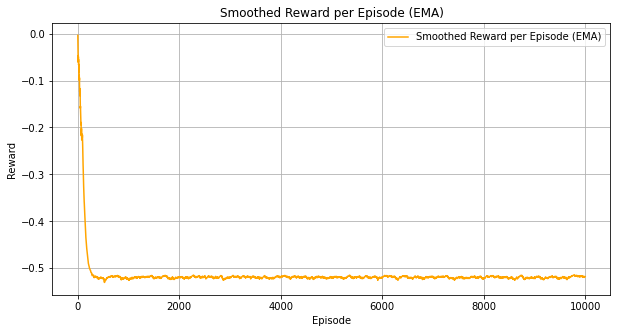

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reward_list_ema(reward_list, alpha=0.02):
    # Calculate Exponential Moving Average
    ema_rewards = []
    ema = 0
    for reward in reward_list:
        ema = alpha * reward + (1 - alpha) * ema
        ema_rewards.append(ema)
    
    plt.figure(figsize=(10, 5))
    plt.plot(ema_rewards, label='Smoothed Reward per Episode (EMA)', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Smoothed Reward per Episode (EMA)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_reward_list_ema(reward_list)


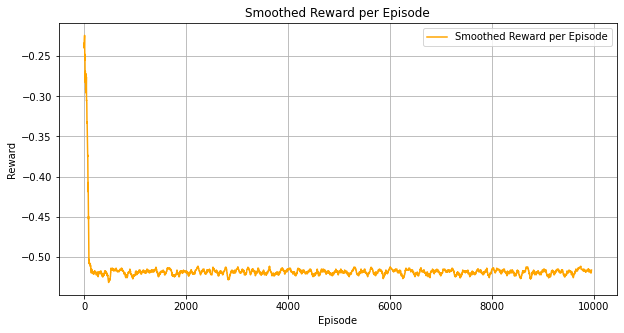

In [19]:
def plot_reward_list(reward_list, window_size=50):
    # Calculate the moving average of rewards
    smoothed_rewards = np.convolve(reward_list, np.ones(window_size)/window_size, mode='valid')
    
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed_rewards, label='Smoothed Reward per Episode', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Smoothed Reward per Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_reward_list(reward_list)


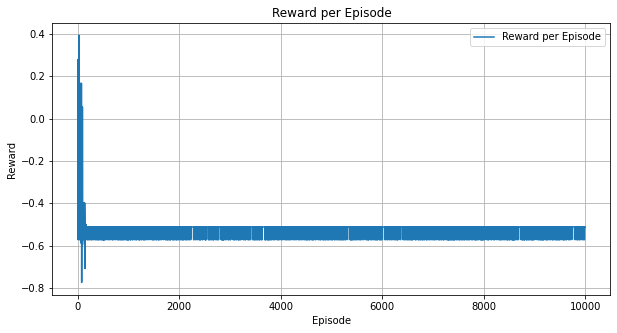

In [20]:
def plot_episode_rewards(episode_rewards, window_size=50):
    
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label='Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward per Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_episode_rewards(reward_list)

In [21]:
reward_list


[-0.18452380952380953,
 -0.42857142857142855,
 -0.1428571428571429,
 -0.42857142857142855,
 -0.42857142857142855,
 -0.5714285714285714,
 -0.5,
 -0.5,
 0.27976190476190466,
 0.27976190476190466,
 -0.3928571428571428,
 0.1666666666666667,
 -0.4107142857142857,
 -0.3095238095238094,
 0.27976190476190466,
 -0.36309523809523825,
 -0.3571428571428571,
 0.053571428571428624,
 -0.05952380952380948,
 -0.5714285714285714,
 -0.5059523809523809,
 0.16666666666666666,
 0.3928571428571428,
 -0.5416666666666666,
 -0.42857142857142855,
 0.053571428571428624,
 -0.3928571428571429,
 -0.5714285714285714,
 0.3928571428571427,
 -0.2857142857142857,
 -0.255952380952381,
 -0.2857142857142857,
 0.16666666666666666,
 -0.5714285714285714,
 -0.5119047619047619,
 -0.494047619047619,
 -0.3392857142857142,
 0.16666666666666669,
 -0.3571428571428571,
 0.16666666666666666,
 -0.5059523809523809,
 -0.2500000000000001,
 -0.38095238095238093,
 -0.059523809523809486,
 -0.05952380952380947,
 0.16666666666666655,
 -0.535714

# Add memory and detach hidden state at the end

In [26]:
class GTrXL(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=256, n_layers=4, n_heads=4, memory_size=512):
        super(GTrXL, self).__init__()
        
        self.embedding = nn.Linear(obs_dim, hidden_dim)
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=n_layers)
        
        # Gating for memory
        self.gating_layer = nn.GRUCell(hidden_dim, hidden_dim)
        self.actor = nn.Linear(hidden_dim, action_dim)
        self.critic = nn.Linear(hidden_dim, 1)

        self.hidden_dim = hidden_dim
        self.memory_size = memory_size

    def forward(self, x, hidden_state, memory=None):
        
        batch_size = x.size(0)
        x = self.embedding(x)
        if memory is None:
            memory = torch.zeros(self.memory_size, batch_size, self.hidden_dim).to(x.device)
        
        if memory.size(1) != batch_size:  # Handle batch size mismatch
            memory = torch.zeros(self.memory_size, batch_size, self.hidden_dim).to(x.device)

        x = x.unsqueeze(0)  # Add a sequence dimension
        memory = torch.cat((memory, x), dim=0)[-self.memory_size:]  # Rolling memory buffer

        transformer_out = self.transformer(memory)  # Includes memory
        
        x = transformer_out[-1]  # Use the latest timestep
        if hidden_state is None:
            hidden_state = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        hidden_state = self.gating_layer(x, hidden_state)
        action_logits = self.actor(hidden_state)
        value = self.critic(hidden_state)

        return action_logits, value, hidden_state, memory
    
# Fix obs space
# array of 16. for each: -1 = not viewed; -2 = mine; 0-inf = how many neighbor mines
def construct_obs(input_coord, value, size=4):
    grid = np.full((size,size), -1, dtype=int)
    y, x = input_coord
    grid[y,x] = value
    return grid.flatten()

def int_to_tuple(n):
    if not (0 <= n < 16):
        raise ValueError("Input must be an integer between 0 and 15.")
    
    # Calculate the row and column from the integer
    row = n // 4
    col = n % 4
    return (row, col)

# Initialize environment and model
env = MineSweeperEasy()
init_obs = construct_obs((0,0),-1)

input_dim = init_obs.shape[0] 
action_dim = np.prod(env.action_space.nvec)

model = GTrXL(obs_dim=input_dim, action_dim=action_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(env, model, optimizer, num_episodes=1000):
    model.to(device)
    model.train()
    memory = None
    hidden_state = None
    
    for episode in range(num_episodes):
        obs = env.reset()
        obs = torch.tensor(construct_obs((0,0),-1), dtype=torch.float32).to(device)
        done = False
        hidden_state = None
        episode_reward = 0

        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            action_logits, value, hidden_state, memory = model(obs_tensor, hidden_state, memory)

            
#             hidden_state = hidden_state.detach()

            action_prob = torch.softmax(action_logits, dim=-1)
            action = torch.multinomial(action_prob, 1).item()

            # Step the environment
            next_obs, reward, truncated, terminated, _ = env.step(int_to_tuple(action))
            done = truncated or terminated
            next_obs = construct_obs(int_to_tuple(action), next_obs)
            episode_reward += reward

            # Compute loss
            advantage = reward - value.item()
            policy_loss = -torch.log(action_prob[0, action]) * advantage
            value_loss = advantage ** 2
            loss = policy_loss + value_loss

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            obs = next_obs

#         print(f"Episode {episode + 1}, Reward: {episode_reward}")
        reward_list.append(episode_reward)
        hidden_state = hidden_state.detach() if hidden_state is not None else None
        memory = memory.detach() if memory is not None else None
        
        if episode % 2000 == 0:
            save_checkpoint(model, optimizer, episode, save_dir="gtrxl_ms_checkpoint")

train(env, model, optimizer,10000)


/home/james/miniconda3/envs/n_trrl/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-26-05997196b1f0>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

doesn't work since we need to detach from the graph